<a href="https://colab.research.google.com/github/Zh-Gong/Reaction-Diffusion-TensorFlow/blob/main/DiffusionReactionTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import libraries for simulation
import tensorflow as tf
import numpy as np

#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
def DisplayArray(a, fmt='jpeg', rng=[0,1]):
  """Display an array as a picture."""
  a = (a - rng[0])/float(rng[1] - rng[0])*255
  a = np.uint8(np.clip(a, 0, 255))
  f = BytesIO()
  PIL.Image.fromarray(a).save(f, fmt)
  clear_output(wait = True)
  display(Image(data=f.getvalue()))

In [ ]:
def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return tf.constant(a)

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(tf.expand_dims(x, 0), -1)
  y = tf.nn.depthwise_conv2d(x, k, [1, 1, 1, 1], padding='VALID')
  return y[0, :, :, 0]

def laplace(x):
  """Compute the 2D laplacian of an array"""
  laplace_k = make_kernel([[0.25, 0.5, 0.25],
                           [0.5, -3., 0.5],
                           [0.25, 0.5, 0.25]])
  return simple_conv(x, laplace_k)


In [ ]:
# The regular fuction on np:
import numpy as np

def FTCS_2D(dt,dx,dy,T,W,H):

  I=int(W/dx)
  J=int(H/dy)
  result=np.zeros((T+1,I+1,J+1))
  if dt>1/(2*(1/dx**2+1/dy**2)):
    raise ValueError("Try a smaller delta-t!")

  result=np.zeros((T+1,I+1,J+1))
  # set the grid

  # set initial conditions
  result[0,:,:]=(np.cos(np.arange(I+1)*dx*np.pi*2).reshape((I+1,1)))*(np.cos(np.arange(J+1)*dy*np.pi*2))

  gamma=dt/(dx**2)
  lamb=dt/(dy**2)

  for t in range(1,T+1):
    ghost=np.zeros((I+3,J+3))
    ghost[1:-1,1:-1]=result[t-1,:,:]
     # Neumann Boundary
    ghost[0,:]=ghost[2,:]
    ghost[I+2,:]=ghost[I,:]
    ghost[:,0]=ghost[:,2]
    ghost[:,J+2]=ghost[:,J]

    for i in range(1,I+2):
      for j in range(1,J+2):
        R1=gamma*(ghost[i-1,j]+ghost[i+1,j]-2*ghost[i,j])
        R2=lamb*(ghost[i,j-1]+ghost[i,j+1]-2*ghost[i,j])
        result[t,i-1,j-1]=R1+R2+ghost[i,j]+dt*(np.pi**2)*7*ghost[i,j]

  return result

def abs_sol(dt,dx,dy,T,W,H):
  I=int(W/dx)
  J=int(H/dy)
  result=np.zeros((T+1,I+1,J+1))

  XY=(np.cos(np.arange(I+1)*dx*np.pi*2).reshape((I+1,1)))*(np.cos(np.arange(J+1)*dy*np.pi*2))
  XY=XY.reshape((1,I+1,J+1))

  for t in range(T+1):
    result[t,:,:]=np.exp(-t*dt*(np.pi**2))*XY

  return result

In [ ]:
# change to tensorflow, combined convolution
def FTCS_TF(dt,dx,dy,T,W,H):

  I=int(W/dx)
  J=int(H/dy)
  result=np.zeros((T+1,I+1,J+1))
  if dt>1/(2*(1/dx**2+1/dy**2)):
    raise ValueError("Try a smaller delta-t!")

  # set the grid
  result=np.zeros((T+1,I+1,J+1))

  # set initial conditions
  result[0,:,:]=(np.cos(np.arange(I+1)*dx*np.pi*2).reshape((I+1,1)))*(np.cos(np.arange(J+1)*dy*np.pi*2))

  gamma=dt/(dx**2)
  lamb=dt/(dy**2)
  center=1-2*(gamma+lamb)
  center=center+7*dt*(np.pi**2)
  filter=make_kernel([[0, lamb, 0],
                      [gamma, center, gamma],
                      [0, lamb, 0]])
  paddings=[[1,1],[1,1]]


  for t in range(1,T+1):
    # create ghost padding, since Nuemann boundary is 0, we can use 'REFLECT' padding method
    ghost=tf.pad(result[t-1],paddings,'REFLECT')

    # ghost=np.zeros((I+3,J+3))
    # ghost[1:-1,1:-1]=result[t-1,:,:]
    #  # Neumann Boundary
    # ghost[0,:]=ghost[2,:]
    # ghost[I+2,:]=ghost[I,:]
    # ghost[:,0]=ghost[:,2]
    # ghost[:,J+2]=ghost[:,J]

    temp0=simple_conv(ghost,filter)

    result[t,:,:]=temp0

    # Neumann Boundary
    # result[t,0,:]=result[t,1,:]
    # result[t,I,:]=result[t,I-1,:]
    # result[t,:,0]=result[t,:,1]
    # result[t,:,J]=result[t,:,J-1]

  return result

In [ ]:
import time

In [ ]:
start = time.time()
NP1=FTCS_2D(0.0001,0.05,0.05,1000,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 1.213


In [ ]:
start = time.time()
TF1=FTCS_TF(0.0001,0.05,0.05,1000,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 1.108


In [ ]:
start = time.time()
NP1=FTCS_2D(0.0001,0.04,0.04,1000,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 3.674


In [ ]:
start = time.time()
TF1=FTCS_TF(0.0001,0.04,0.04,1000,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 0.928


In [ ]:
start = time.time()
num=FTCS_2D(0.0001,0.025,0.025,1000,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 4.504


In [ ]:
start = time.time()
num=FTCS_TF(0.0001,0.025,0.025,1000,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 1.078


In [ ]:
start = time.time()
num=FTCS_2D(0.0001,0.02,0.02,1000,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 7.047


In [ ]:
start = time.time()
num1=FTCS_TF(0.0001,0.02,0.02,1000,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 1.127


In [ ]:
start = time.time()
num=FTCS_2D(0.0001/4,0.01,0.01,500*4,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 76.4


In [ ]:
start = time.time()
num1=FTCS_TF(0.0001/4,0.01,0.01,500*4,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 4.273


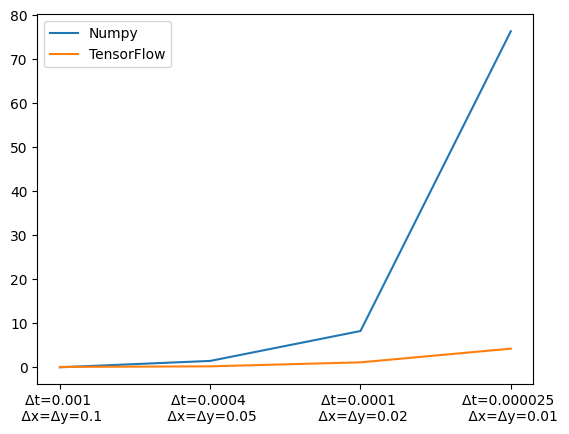

In [ ]:
X=[u'Δt=0.001 \n Δx=Δy=0.1',
    u'Δt=0.0004 \n Δx=Δy=0.05',
   u'Δt=0.0001 \n Δx=Δy=0.02',
   u'Δt=0.000025 \n Δx=Δy=0.01'
]

T_NP=[0.041,1.486,8.284,76.4]
T_TF=[0.121,0.252,1.162,4.273]

plt.plot(X,T_NP,label='Numpy')
plt.plot(X,T_TF,label='TensorFlow')
plt.legend()

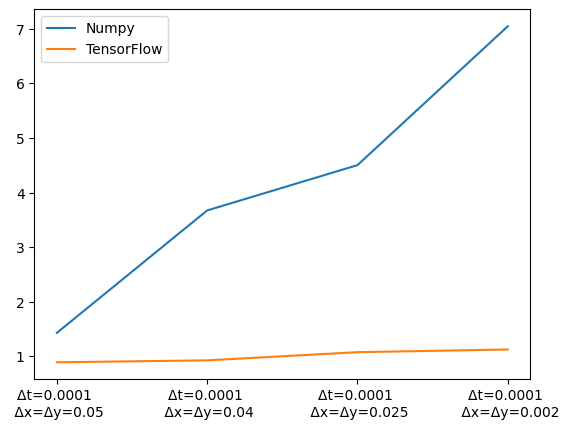

In [ ]:
X=[u'Δt=0.0001 \n Δx=Δy=0.05',
    u'Δt=0.0001 \n Δx=Δy=0.04',
   u'Δt=0.0001 \n Δx=Δy=0.025',
   u'Δt=0.0001 \n Δx=Δy=0.002'
]


T_NP=[1.432,3.674,4.504,7.047]
T_TF=[0.893,0.928,1.078,1.127]

plt.plot(X,T_NP,label='Numpy')
plt.plot(X,T_TF,label='TensorFlow')
plt.legend()

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import animation

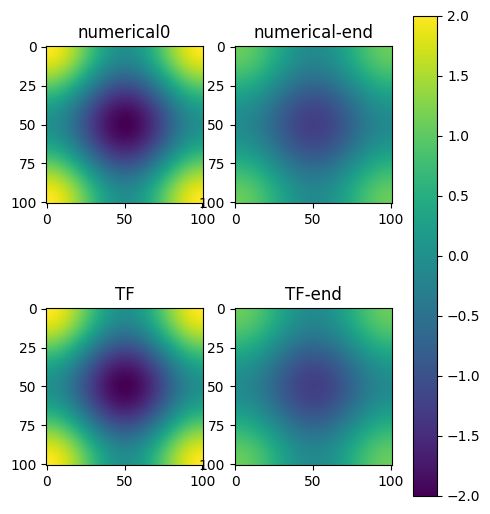

In [ ]:

Nr = 2
Nc = 2

fig, axs = plt.subplots(Nr, Nc)

images = []

images.append(axs[0][0].imshow(num[0]))
images.append(axs[0][1].imshow(num[-1]))
images.append(axs[1][0].imshow(num1[0]))
images.append(axs[1][1].imshow(num1[-1]))

axs[0][0].title.set_text('numerical0')
axs[0][1].title.set_text('numerical-end')
axs[1][0].title.set_text('TF')
axs[1][1].title.set_text('TF-end')

plt.subplots_adjust(bottom=0, right=0.8, top=1)

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)

fig.colorbar(images[0], ax=axs)

fig.show()

## 2 Components

$$
\begin{aligned}
\partial_t u & =1 \nabla^2 u+u-v \\
\partial_t v & =1 \nabla^2 v+0.01u-v
\end{aligned}
$$
Initial:
$$
u_0={1\over 2}-{1\over 4}(\cos 2\pi x+\cos 2\pi y)\\
v_0={1}-{1\over 8}(\cos (2\pi x-\pi)+\cos (2\pi y-\pi))
$$

In [ ]:
# change to tensorflow

def make_kernel(a):
  """Transform a 2D array into a convolution kernel"""
  a = np.asarray(a)
  a = a.reshape(list(a.shape) + [1,1])
  return a

def simple_conv(x, k):
  """A simplified 2D convolution operation"""
  x = tf.expand_dims(x, 0)
  y = tf.nn.conv2d(x, k, [1, 1, 1, 1], padding='VALID')
  return y[0, :, :, :]


def TF_2C(dt,dx,dy,T,W,H):

  I=int(W/dx)
  J=int(H/dy)
  result=np.zeros((T+1,I+1,J+1,2))
  if dt>1/(2*(1/dx**2+1/dy**2)):
    raise ValueError("Try a smaller delta-t!")


  # set initial conditions
  result[0,:,:,0]=0.5-0.25*((np.cos(np.arange(I+1)*dx*np.pi*2).reshape((I+1,1)))+(np.cos(np.arange(J+1)*dy*np.pi*2)))
  result[0,:,:,1]=0.25-0.125*((np.cos(np.arange(I+1)*dx*np.pi*2-np.pi).reshape((I+1,1)))+(np.cos(np.arange(J+1)*dy*np.pi*2-np.pi)))

  gamma=dt/(dx**2)
  lamb=dt/(dy**2)
  center=1-2*(gamma+lamb)
  fu_0=make_kernel([[0, lamb, 0],
                      [gamma, center+dt, gamma],
                      [0, lamb, 0]])
  fu_1=make_kernel([[0,0,0],
                    [0,-dt,0],
                    [0,0,0]])
  fu=np.concatenate((fu_0,fu_1),axis=2)
  fv_0=make_kernel([[0,0,0],
                    [0,dt*0.01,0],
                    [0,0,0]])
  fv_1=make_kernel([[0, lamb, 0],
                      [gamma, center, gamma],
                      [0, lamb, 0]])
  fv=np.concatenate((fv_0,fv_1),axis=2)
  filter=np.concatenate((fu,fv),axis=3)
  filter=tf.constant(filter)

  paddings=[[1,1],[1,1],[0,0]]

  for t in range(1,T+1):

    ghost=tf.pad(result[t-1],paddings,"REFLECT")

    temp=simple_conv(ghost,filter)

    result[t,:,:,:]=temp


  return result[:,:,:,0], result[:,:,:,1]

## Lotka–Volterra equations in Space

$$
\begin{aligned}
\partial_t u & =0.1 \nabla^2 u+50u-200uv \\
\partial_t v & =0.3 \nabla^2 v+100uv-100v
\end{aligned}
$$
Initial:
$$
u_0={1\over 2}-{1\over 4}(\cos 2\pi x+\cos 2\pi y)\\
v_0={1}-{1\over 2}(\cos (2\pi x-\pi)+\cos (2\pi y-\pi))
$$

In [ ]:
def TF_LV(dt,dx,dy,T,W,H):

  I=int(W/dx)
  J=int(H/dy)
  result=np.zeros((T+1,I+1,J+1,2))
  if dt>1/(2*(1/dx**2+1/dy**2)):
    raise ValueError("Try a smaller delta-t!")


  # set initial conditions
  result[0,:,:,0]=0.5-0.25*((np.cos(np.arange(I+1)*dx*np.pi*2).reshape((I+1,1)))+(np.cos(np.arange(J+1)*dy*np.pi*2)))
  result[0,:,:,1]=1-0.5*((np.cos(np.arange(I+1)*dx*np.pi*2-np.pi).reshape((I+1,1)))+(np.cos(np.arange(J+1)*dy*np.pi*2-np.pi)))

  gamma_u=0.1*dt/(dx**2)
  lamb_u=0.1*dt/(dy**2)
  center_u=1-2*(gamma_u+lamb_u)
  gamma_v=0.3*dt/(dx**2)
  lamb_v=0.3*dt/(dy**2)
  center_v=1-2*(gamma_v+lamb_v)

  fu_0=make_kernel([[0, lamb_u, 0],
                      [gamma_u, center_u+dt*50, gamma_u],
                      [0, lamb_u, 0]])
  fu_1=make_kernel([[0,0,0],
                    [0,0,0],
                    [0,0,0]])
  fu=np.concatenate((fu_0,fu_1),axis=2)
  fv_0=make_kernel([[0,0,0],
                    [0,0,0],
                    [0,0,0]])
  fv_1=make_kernel([[0, lamb_v, 0],
                      [gamma_v, center_v-dt*100, gamma_v],
                      [0, lamb_v, 0]])
  fv=np.concatenate((fv_0,fv_1),axis=2)
  filter=np.concatenate((fu,fv),axis=3)
  filter=tf.constant(filter)

  paddings=[[1,1],[1,1],[0,0]]

  for t in range(1,T+1):

    uv=result[t-1]
    ghost=tf.pad(uv,paddings,"REFLECT")

    temp=simple_conv(ghost,filter)

    uv=tf.math.multiply(uv[:,:,0],uv[:,:,1])
    uv=tf.expand_dims(uv,-1)
    uv=tf.concat([-200*dt*uv,100*dt*uv],2)

    temp=tf.math.add(temp,uv)

    result[t,:,:,:]=temp


  return result[:,:,:,0], result[:,:,:,1]

In [ ]:
start = time.time()
tf_sol_u,tf_sol_v=TF_2C(0.0001,0.02,0.02,1000,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 1.91


In [ ]:
start = time.time()
tf_sol_u,tf_sol_v=TF_LV(0.0001,0.02,0.02,5000,1,1)
print('Complete:', round(time.time()-start,3))

Complete: 10.529


In [ ]:
def plot4(t):
  Nr = 4
  Nc = 4

  t=int(t/4)

  fig, axs = plt.subplots(Nr, Nc)

  images = []

  for col in range(4):

    images.append(axs[col][0].imshow(num_u[col*t]))
    images.append(axs[col][1].imshow(num_v[col*t]))
    images.append(axs[col][2].imshow(tf_sol_u[col*t]))
    images.append(axs[col][3].imshow(tf_sol_v[col*t]))

    axs[col][0].title.set_text('numpy_u'+str(col*t))
    axs[col][1].title.set_text('numpy_v'+str(col*t))
    axs[col][2].title.set_text('TF_u'+str(col*t))
    axs[col][3].title.set_text('TF-v'+str(col*t))

  plt.subplots_adjust(bottom=0, right=2, top=2.2)

  # Find the min and max of all colors for use in setting the color scale.
  vmin = min(image.get_array().min() for image in images)
  vmax = max(image.get_array().max() for image in images)
  norm = colors.Normalize(vmin=vmin, vmax=vmax)
  for im in images:
    im.set_norm(norm)

  fig.colorbar(images[0], ax=axs)

  fig.show()

In [ ]:
def plot5(t):
  Nr = 2
  Nc = 6

  t=int(t/5)

  fig, axs = plt.subplots(Nr, Nc)

  images = []

  for row in range(6):

    images.append(axs[0][row].imshow(tf_sol_u[row*t]))
    images.append(axs[1][row].imshow(tf_sol_v[row*t]))

    axs[0][row].title.set_text('u at T= %.3f'%(row*t*0.0001))
    axs[1][row].title.set_text('v at T= %.3f'%(row*t*0.0001))

  plt.subplots_adjust(bottom=0, right=2, top=0.9)

  # Find the min and max of all colors for use in setting the color scale.
  vmin = min(image.get_array().min() for image in images)
  vmax = max(image.get_array().max() for image in images)
  norm = colors.Normalize(vmin=vmin, vmax=vmax)
  for im in images:
    im.set_norm(norm)

  fig.colorbar(images[0], ax=axs)

  fig.show()

In [ ]:
plot4(800)

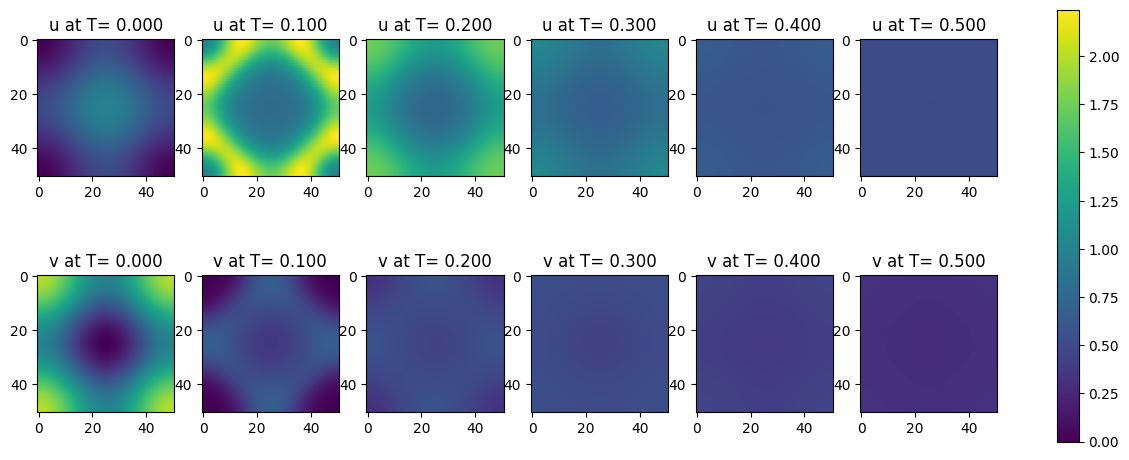

In [ ]:
plot5(5000)

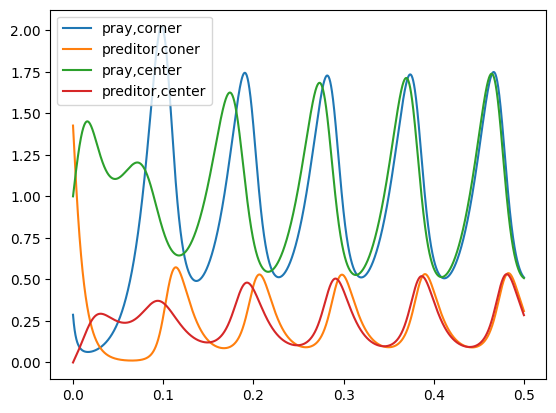

In [ ]:
plt.plot(np.linspace(0,0.5,5001),tf_sol_u[:,41,41],label='pray,corner')
plt.plot(np.linspace(0,0.5,5001),tf_sol_v[:,41,41],label='preditor,coner')
plt.plot(np.linspace(0,0.5,5001),tf_sol_u[:,25,25],label='pray,center')
plt.plot(np.linspace(0,0.5,5001),tf_sol_v[:,25,25],label='preditor,center')
plt.legend()